
# ERT field data with Topography

using Tom's data! For line 01.

First adding our imports.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
import os

Now call the data file and load it.

In [13]:
os.chdir(r'C:\Users\sydne\git\erth370\erth370-w2026-sydpas\pygimex\ert\extra_files')
print(f'Directory of extra files: {os.getcwd()}')  # shows your current working directory

filename = r'C:\Users\sydne\git\erth370\erth370-w2026-sydpas\data\line01\Line01_DD-Grad_TOPO_combined.DAT'
data = ert.load(filename)
print(data)

26/01/26 - 19:10:31 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv


Directory of extra files: C:\Users\sydne\git\erth370\erth370-w2026-sydpas\pygimex\ert\extra_files
Data: Sensors: 121 data: 7372, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


Let us first have a look at the topography contained in the data!

From chat explanation: "...we are interpolating the elevation at each electrode’s x-position by linearly estimating between the nearest topo points. This is done because the DAT file gives topography points at certain x-locations (say, [9.6, 14.7, 19.7, ...]), but electrodes might be at [0, 5, 10, 15, 20, ..., 400]."

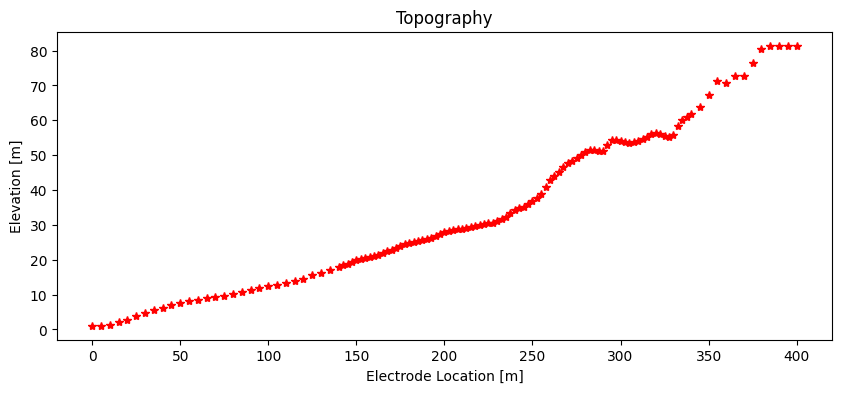

In [16]:
topo = []
start_line = 7386

with open(filename) as f:  # reading DAT line by line
    for i, line in enumerate(f):
        if i < start_line:  # if not topo data yet, continue
            continue
        parts = line.split()  # split using whitespace
        if len(parts) == 2: # if data has 2 columns it is topo data so add to the list
            topo.append([float(parts[0]), float(parts[1])])
topo = np.array(topo)  # convert to numpy array

x_elec = pg.x(data)  # get x pos of all electrodes
z_elec = np.interp(x_elec, topo[:,0], topo[:,1])  # interpolate topo at each electrode

x_elec = np.array(pg.x(data))  # convert RVector to numpy

# now we ensure topo covers all electrodes at both ends
if topo[0,0] > x_elec.min():  # if topo is to the right of (after) electrode
    topo = np.vstack(([x_elec.min(), topo[0,1]], topo))
if topo[-1,0] < x_elec.max():  # if topo is to the left of (before) electrode
    topo = np.vstack((topo, [x_elec.max(), topo[-1,1]]))


# second interp of topo at electrode positions
z_interp = np.interp(x_elec, topo[:,0], topo[:,1])

# set electrode positions in data
data.setSensorPositions(pg.PosVector(np.c_[x_elec, z_interp]))  # combine into 2D array, convert to gimli pos vector, and update elec pos in ERT dataset

# plot to check
plt.figure(figsize=(10,4))
plt.plot(x_elec, z_interp, 'r*')
plt.xlabel('Electrode Location [m]')
plt.ylabel('Elevation [m]')
plt.title('Topography')
plt.show()



The data file does not contain geometric factors (token field 'k'),
so we create them based on the given topography.



In [15]:
k0 = ert.createGeometricFactors(topo)  # the analytical one
data['k'] = ert.createGeometricFactors(topo, numerical=True)

ArgumentError: Python argument types in
    pgcore._pygimli_.geometricFactors(numpy.ndarray)
did not match C++ signature:
    geometricFactors(GIMLI::DataContainerERT data, int dim=3, bool forceFlatEarth=False)

It might be interesting to see the topography effect, i.e the ratio between
the numerically computed geometry factor and the analytical formula after
Rücker et al. (2006). We display it using a colormap with neutral white.



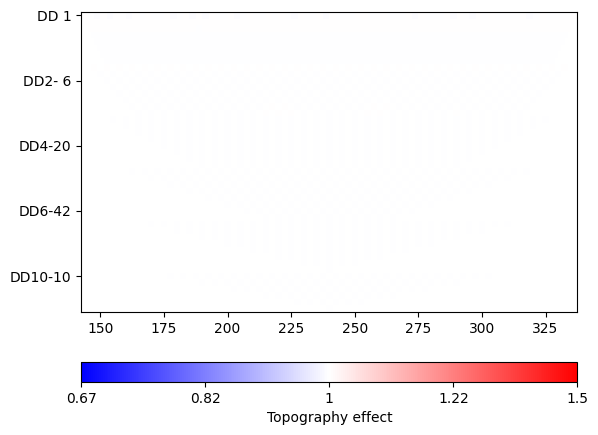

In [ ]:
_ = ert.showData(data, vals=k0/ data['k'], label='Topography effect',
                 cMin=2/3, cMax=3/2, logScale=True, cMap="bwr")

We can now compute the apparent resistivity and display it, once with the
wrong analytical formula and once with the numerical values in data['k']



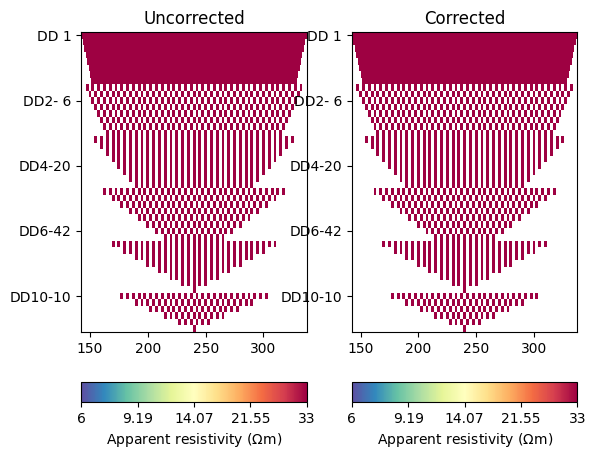

In [ ]:
data['rhoa'] = data['r'] * data['k']
kw = dict(cMin=6, cMax=33)
fig, ax = plt.subplots(ncols=2)
data.show(data['r']*k0, ax=ax[0], **kw);
data.show(ax=ax[1], **kw)
ax[0].set_title('Uncorrected')
ax[1].set_title('Corrected');

The data container does not necessarily contain data errors data errors
(token field 'err'), requiring us to enter data errors. We can let the
manager guess some defaults for us automaticly or set them manually



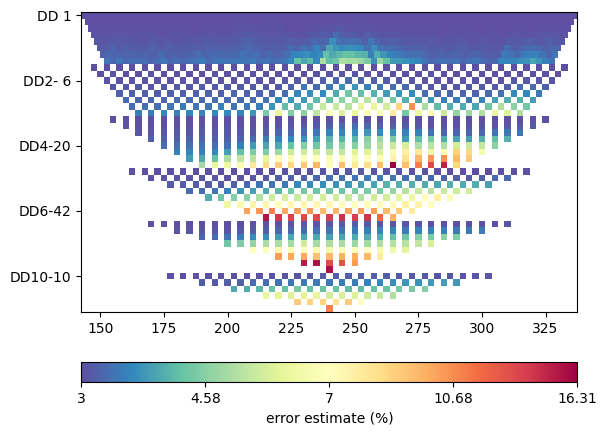

In [ ]:
data.estimateError(relativeError=0.03, absoluteUError=5e-5)
# which internally calls
# data['err'] = ert.estimateError(data, ...)  # can also set manually
_ = data.show(data['err']*100, label='error estimate (%)')

We initialize the ERTManager for further steps and eventually inversion.



In [ ]:
mgr = ert.ERTManager(data)

Now the data have all necessary fields ('rhoa', 'err' and 'k') so we can run
the inversion. The inversion mesh will be created with some optional values
for the parametric mesh generation.




26/01/26 - 16:58:27 - pyGIMLi - INFO - Found 2 regions.
26/01/26 - 16:58:27 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
26/01/26 - 16:58:27 - pyGIMLi - INFO - Found 2 regions.
26/01/26 - 16:58:27 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
26/01/26 - 16:58:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
26/01/26 - 16:58:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
26/01/26 - 16:58:27 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6177 Cells: 11784 Boundaries: 9122
26/01/26 - 16:58:27 - pyGIMLi - INFO - Use median(data values)=620.4489011935883
26/01/26 - 16:58:27 - pyGIMLi - INFO - Created startmodel from forward operator:2089, min/max=620.448901/620.448901
26/01/26 - 16:58:27 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000025B6AAC9C10>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 52.47/2214
min/max (error): 3%/16.31%
min/max (start model): 620/620
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  376.85
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  220.73 (dPhi = 41.06%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  168.90 (dPhi = 23.43%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =  105.22 (dPhi = 37.58%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   68.03 (dPhi = 35.14%) lam: 10.0
--------------------------------------------------

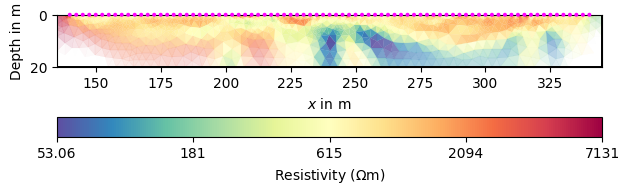

In [ ]:
mod = mgr.invert(data, lam=10, verbose=True,
                 paraDX=0.3, paraMaxCellSize=10, paraDepth=20, quality=33.6)
ax, cb = mgr.showResult()

We can view the resulting model in the usual way.



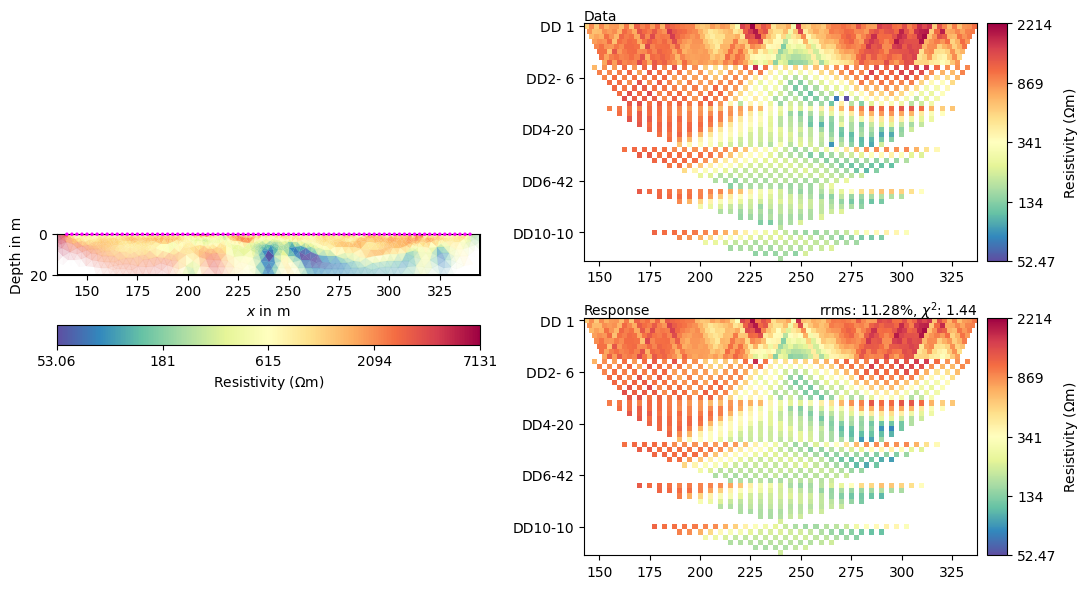

In [ ]:
_ = mgr.showResultAndFit()
# np.testing.assert_approx_equal(ert.inv.chi2(), 1.10883, significant=3)

Or just plot the model only using your own options.



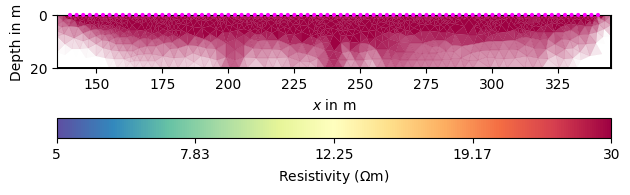

In [ ]:
ax, cb = mgr.showResult(mod, cMin=5, cMax=30, cMap="Spectral_r", logScale=True)